In [1]:
import numpy as np
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.models.plr_ash import PenalizedMrASH

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from pymir import R_utils

def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2):
    w = np.zeros(k)
    w[0] = 0.0
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [2]:
def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, intercept = 0):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    plt.tight_layout()
    plt.show()

mr.ash.pen terminated at iteration 922.


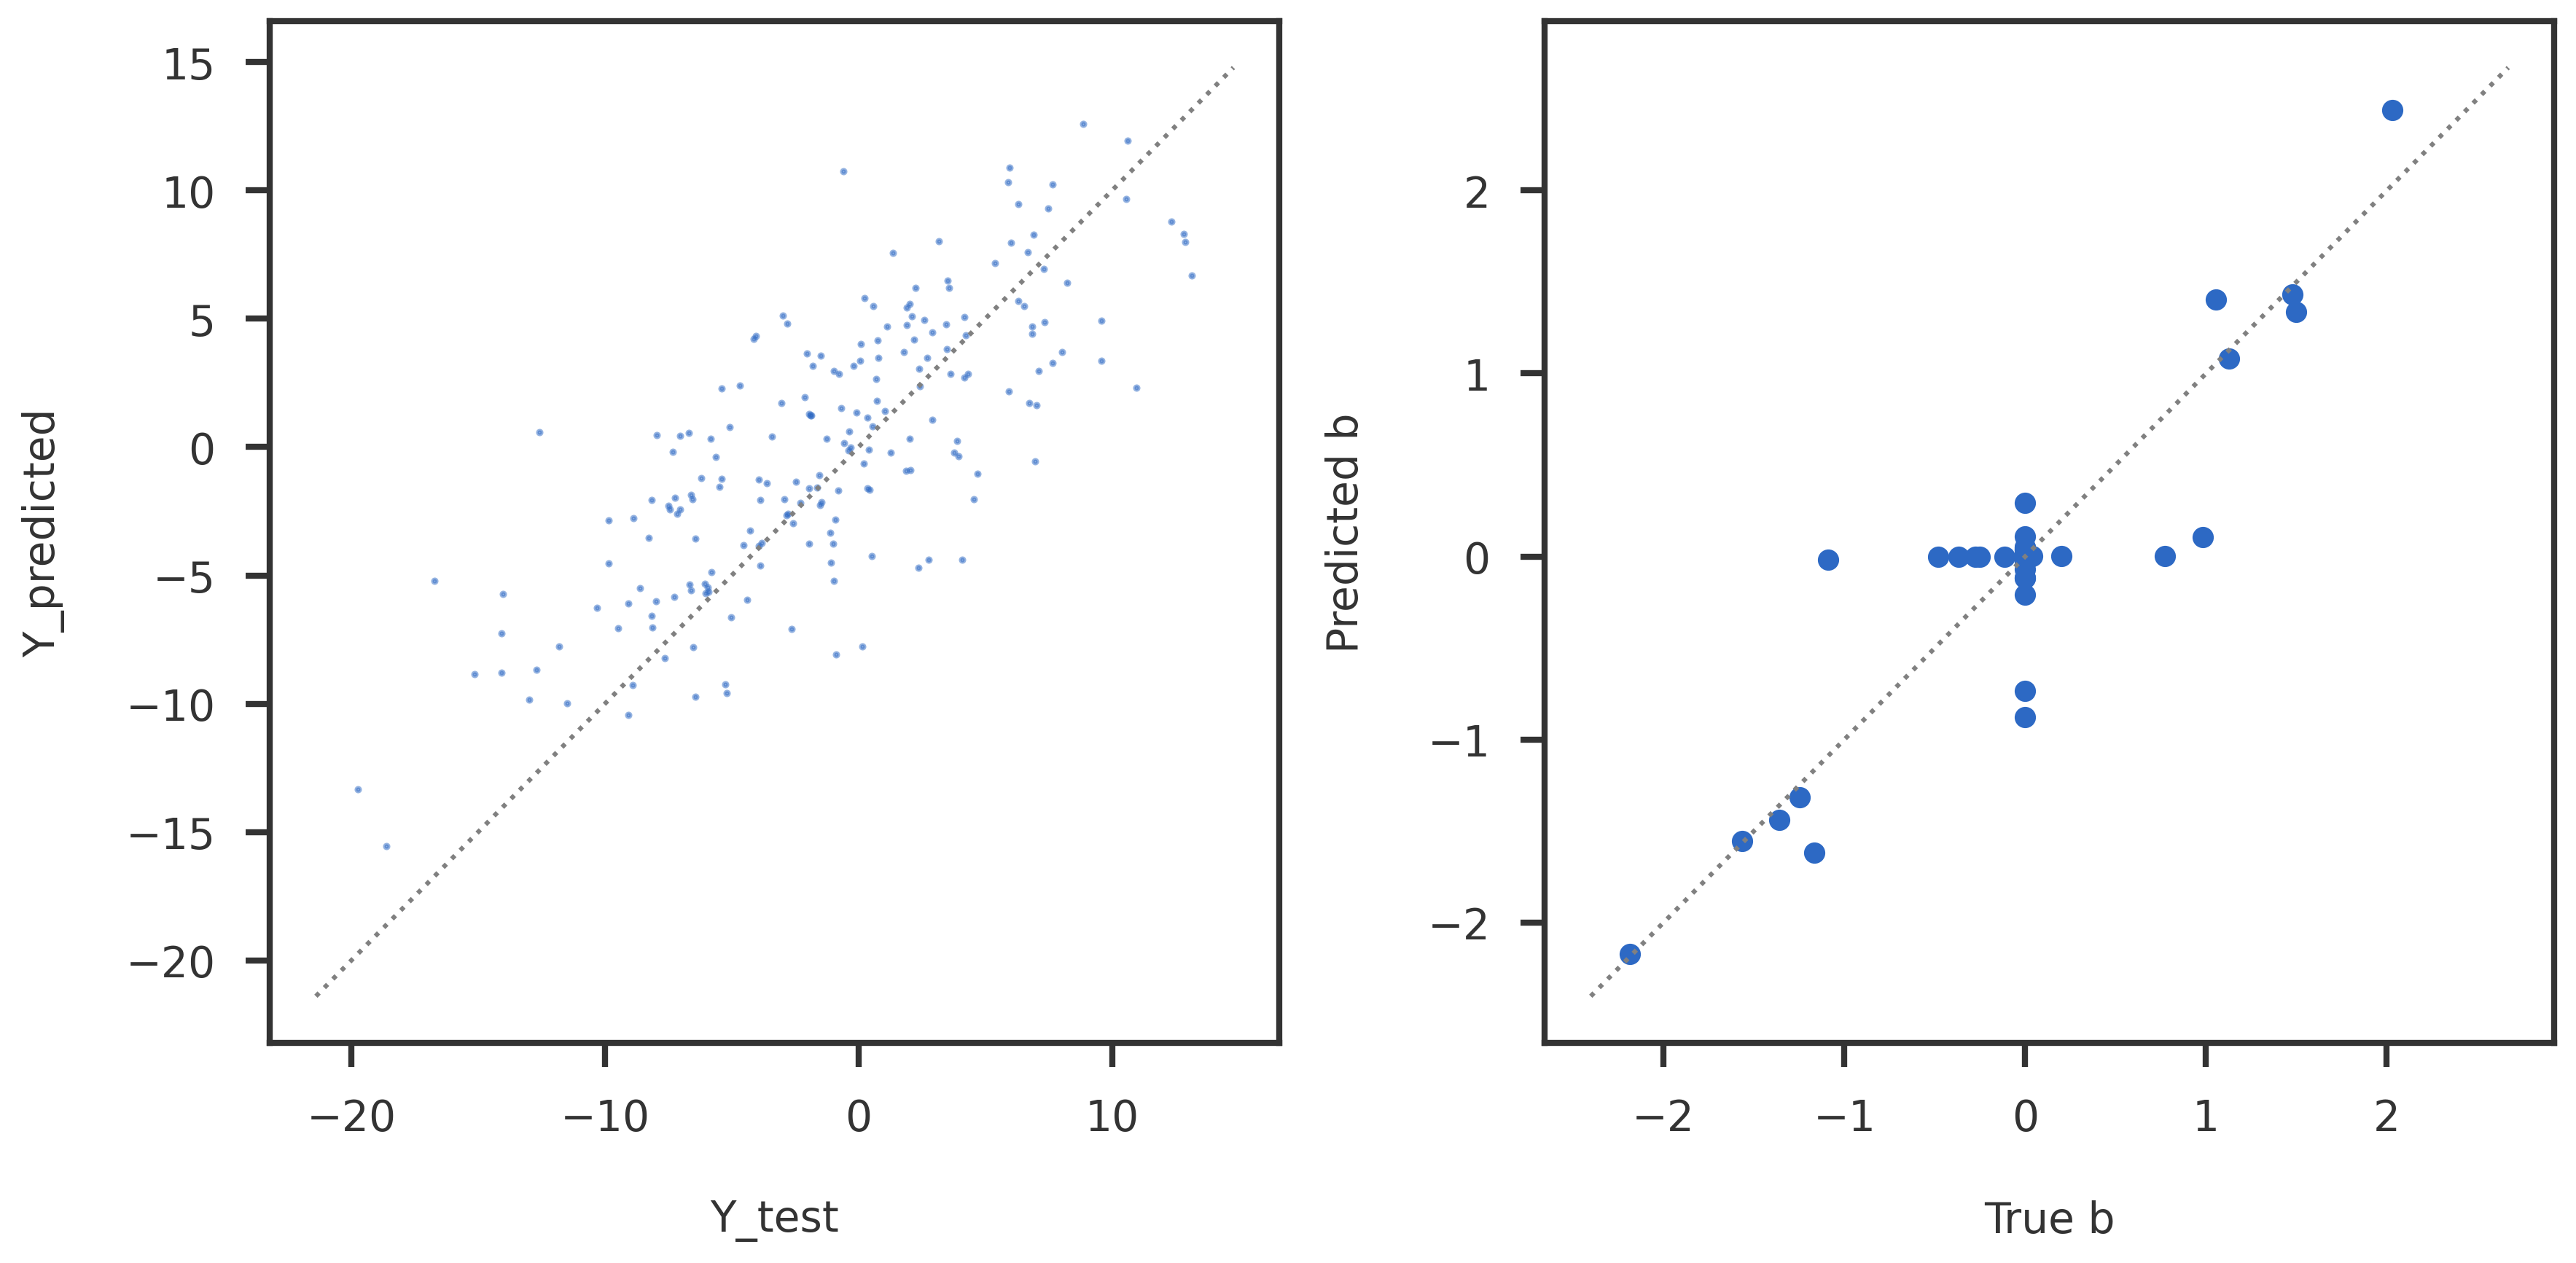

In [3]:
n = 200
p = 2000
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.0, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

## Optimize
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, plr_lbfgs.coef)

In [4]:
import rpy2.robjects as robj
import rpy2.robjects.vectors as rvec
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
numpy2ri.activate()
from rpy2.robjects.conversion import localconverter

def mrash_wrapR_rds(X, y, sk, binit, wkinit, s2init, maxiter):
    import os
    import tempfile
    import subprocess
    rscript_file = 'fit_mrash.R'
    
    os_handle, data_rds_file = tempfile.mkstemp(suffix = ".rds")
    datadict = {'X': X, 'y': y, 'sk2': np.square(sk), 
                'binit': binit, 'winit': wkinit, 's2init': s2init}
    R_utils.save_rds(datadict, data_rds_file)
    os_handle, out_rds_file = tempfile.mkstemp(suffix = ".rds")
    cmd  = ["Rscript",   rscript_file]
    cmd += ["--outfile", out_rds_file]
    cmd += ["--infile",  data_rds_file]
    cmd += ["--maxiter", f"{maxiter}"]

    process = subprocess.Popen(cmd,
                               stdout = subprocess.PIPE,
                               stderr = subprocess.PIPE
                              )
    res     = process.communicate()
    
    print(res[0].decode('utf-8'))

    if len(res[1].decode('utf-8')) > 0:
        print("")
        print("ERROR ==>")
        print(res[1].decode('utf-8'))

    retcode = process.returncode
    vebout  = R_utils.load_rds(out_rds_file) if retcode == 0 else None
    if os.path.exists(data_rds_file): os.remove(data_rds_file)
    if os.path.exists(out_rds_file):  os.remove(out_rds_file)
    return vebout

def array_reduce(x):
    ndim = x.ndim
    if ndim == 1:
        res = x[0] if x.shape[0] == 1 else x
    elif ndim == 2:
        res = x.reshape(-1) if x.shape[1] == 1 else x
    return res 
    

def robj2dict_recursive(robj):
    res = dict()
    for key in robj.names:
        elem = robj.rx2(key)
        if isinstance(elem, (rvec.FloatVector, rvec.IntVector)):
            res[key] = array_reduce(np.array(elem))
        elif isinstance(elem, rvec.StrVector):
            print(f"WARNING: Abnormal StrVector output")
        elif isinstance(elem, np.ndarray):
            res[key] = array_reduce(elem)
        elif isinstance(elem, rvec.ListVector):
            res[key] = robj2dict_recursive(elem)
    return res


def mrash_wrapR(X, y, sk, binit, wkinit, s2init, maxiter, epstol = 1e-12, convtol = 1e-8):

    #from rpy2.robjects import pandas2ri
    #pandas2ri.activate()
    
    #dotdict = {'mr.ash': '_mr_ash', 'max.iter': '_maxiter', 'beta.init': '_betainit'}
    #mrashR = importr('mr.ash.alpha', robject_translations = dotdict)
    mrashR = importr('mr.ash.alpha')
    
    n, p = X.shape
    r_X      = robj.r.matrix(X, nrow = n, ncol = p)
    r_y      = rvec.FloatVector(y)
    r_sk2    = rvec.FloatVector(np.square(sk))
    r_binit  = rvec.FloatVector(binit)
    r_wkinit = rvec.FloatVector(wkinit)
    r_tol    = rvec.ListVector({'epstol': epstol, 
                                'convtol': convtol})
    
    r_fit = mrashR.mr_ash(r_X, r_y, 
                          standardize = False, intercept = True,
                          max_iter = maxiter,
                          sa2 = r_sk2,
                          beta_init = r_binit,
                          pi = r_wkinit,
                          sigma2 = s2init,
                          tol = r_tol
                         )

    #print(r_fit)

    with localconverter(robj.default_converter):
        r_fit_conv = robj.conversion.rpy2py(r_fit)
    
    fit_dict = robj2dict_recursive(r_fit)

    return fit_dict, r_fit

In [5]:
binit = plr_lbfgs.coef
wkinit = plr_lbfgs.prior
s2init = plr_lbfgs.residual_var
# binit  = np.zeros(p)
# wkinit = wk
# s2init = 1.0
ashRout, ashRout_r = mrash_wrapR(X, y, sk, binit, wkinit, s2init, 5000)

Mr.ASH terminated at iteration 23.


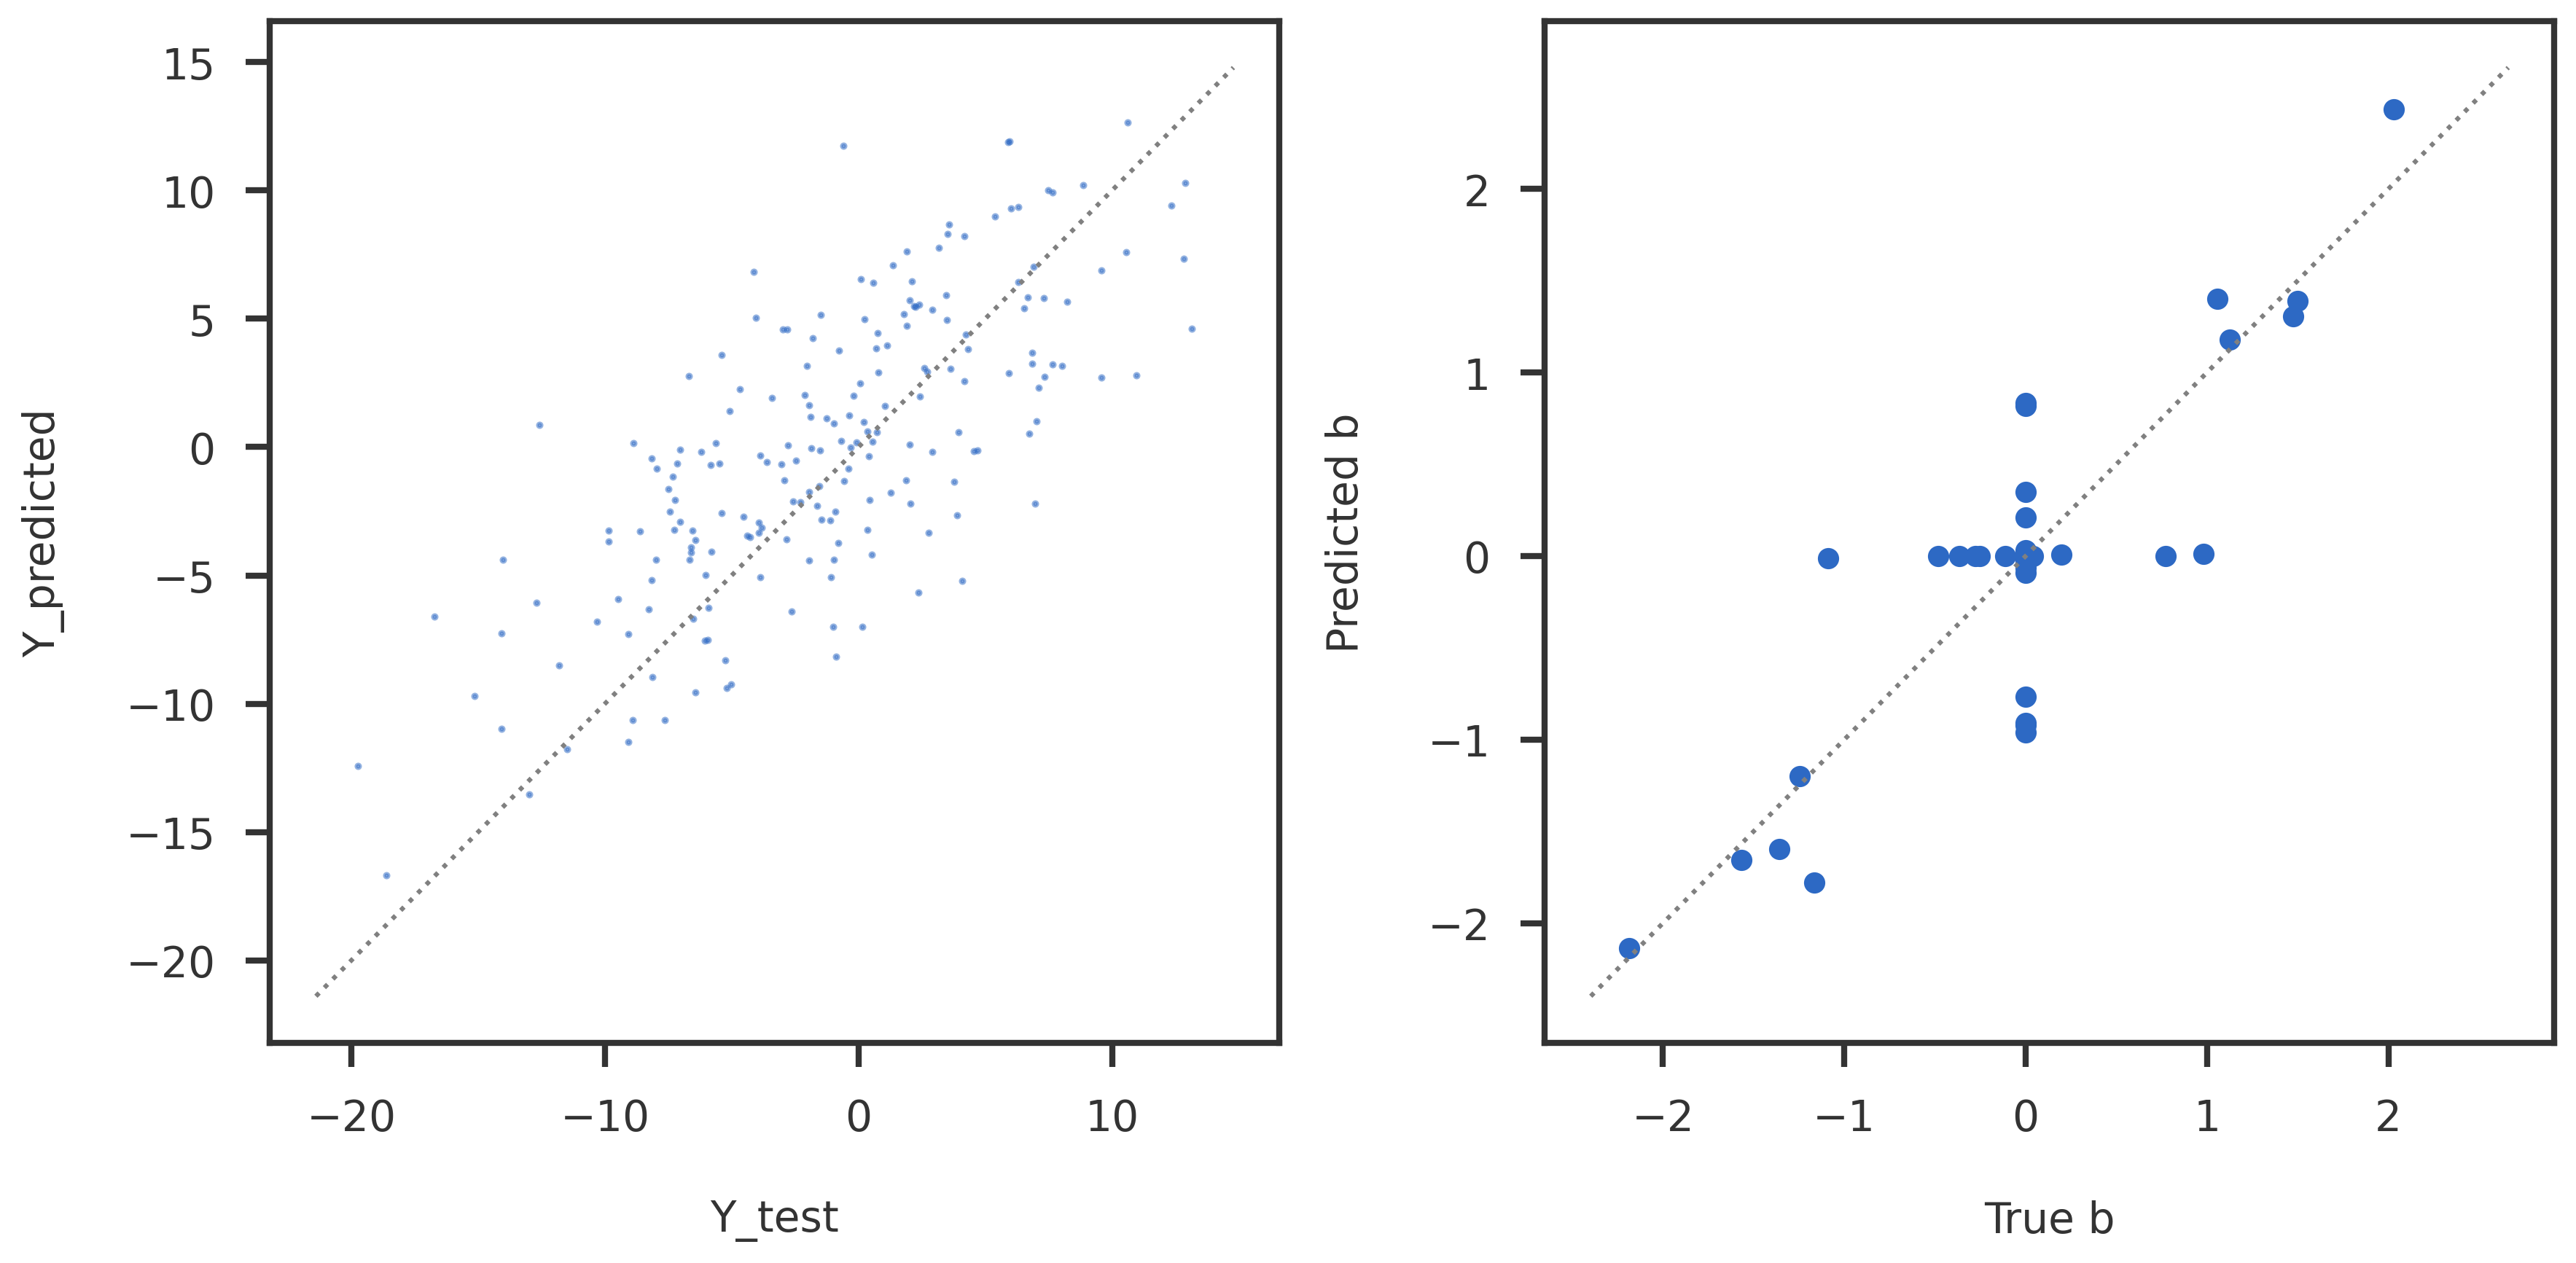

In [6]:
## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, ashRout['beta'])

In [7]:
binit = plr_lbfgs.coef
wkinit = plr_lbfgs.prior
s2init = plr_lbfgs.residual_var
ashRout_rds = mrash_wrapR_rds(X, y, sk, binit, wkinit, s2init, 5000)

Mr.ASH terminated at iteration 23.


ERROR ==>
Warning message:
In mr.ash.alpha::mr.ash(as.matrix(data$X), as.vector(data$y), max.iter = opt$maxiter,  :
  The mixture proportion associated with the largest prior variance is greater than zero; this indicates that the model fit could be improved by using a larger setting of the prior variance. Consider increasing the range of the variances "sa2".



/home/saikat/Documents/work/sparse-regression/mr-ash-penalized/mr-ash-pen/src/mrashpen/inference/mrash_wrapR.py
Mr.ASH terminated at iteration 23.


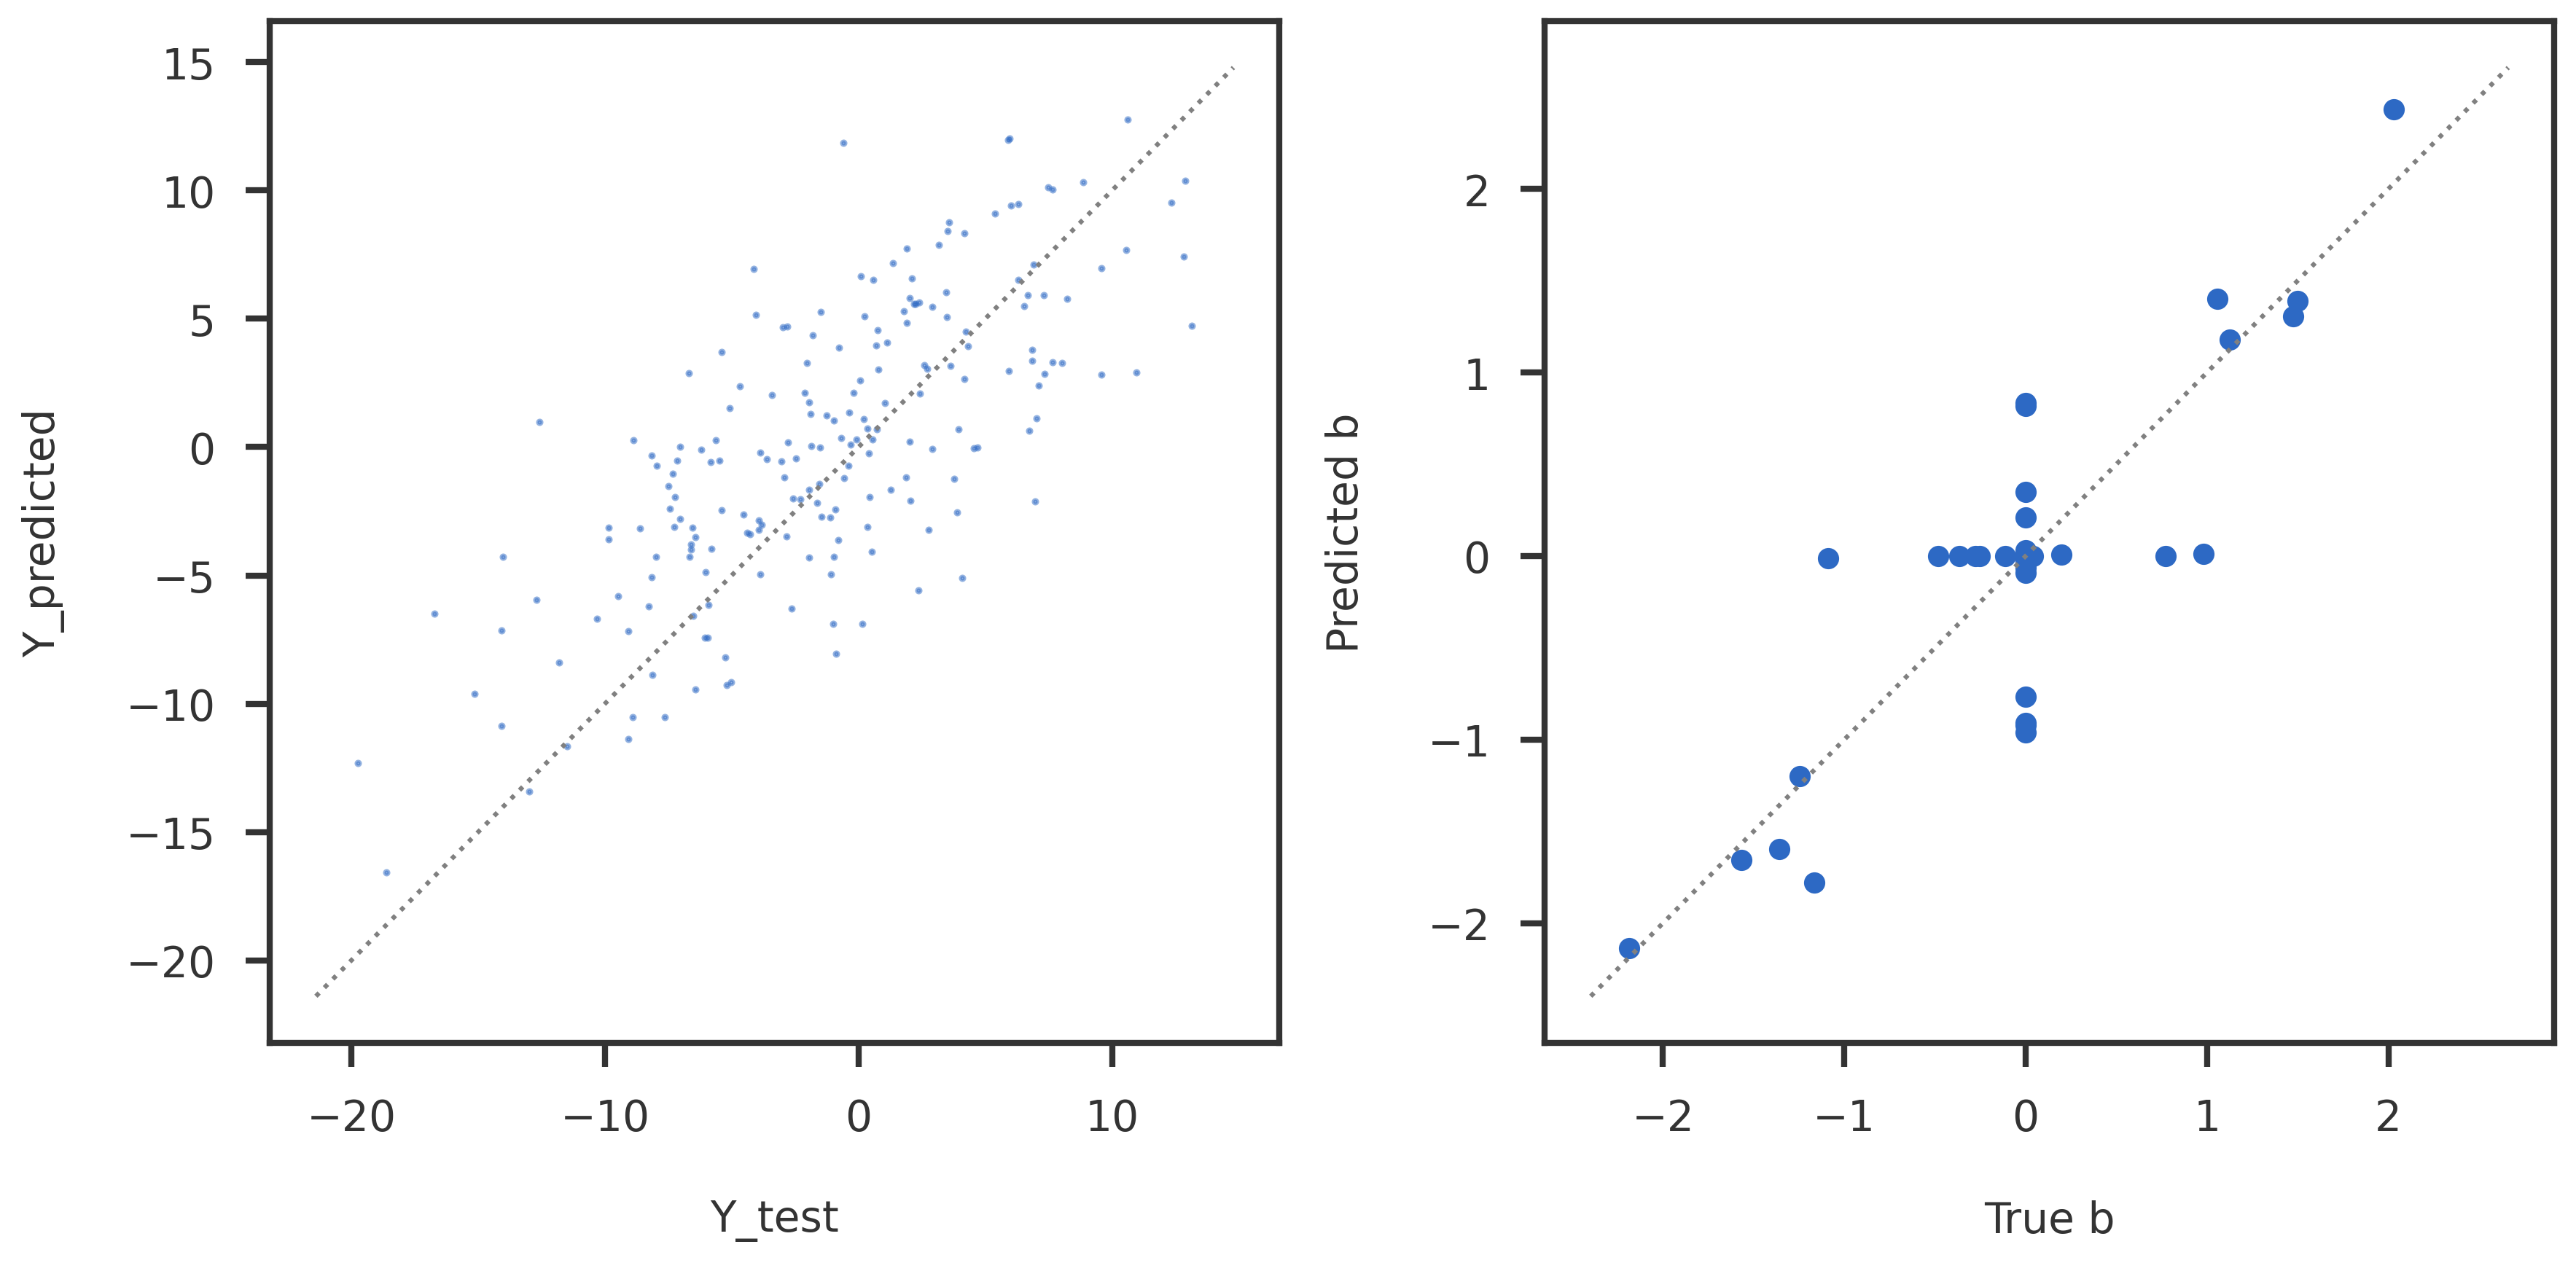

In [8]:
from mrashpen.inference.mrash_wrapR import MrASHR

## Mr.ASH.alpha on optimized result
mrash_r = MrASHR(option = "r2py", debug = True)
mrash_r.fit(X, y, sk, 
            binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, mrash_r.coef, intercept = mrash_r.intercept)